In [ ]:
import datetime

import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import bigquery
from google.cloud.bigquery import Client
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error)


In [ ]:
# Constants

# Project and dataset where the model will be saved
PROJECT = "csce5214-p1"
DATASET = "csce5214_iowa_sales"

# Source table for training data
SOURCE_TABLE = "'bigquery-public-data`.iowa_liquor_sales.sales"

#MODEL_NAME_PREFIX = "bqml_arimaplus_dw_"
#MODEL_TYPE = "arima_plus"

#HORIZON = 30
#GRANULARITY = "DAILY"

In [ ]:
client = Client(project=PROJECT)

In [ ]:
query = """
SELECT *  FROM `bigquery-public-data.iowa_liquor_sales.sales`
WHERE date between '2019-01-01' and '2022-06-30'
#AND zip_code = 50310.0
"""
query_job = client.query(query)

In [31]:
df = query_job.to_dataframe()

In [32]:
df.head(10)

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,...,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,INV-20842300016,2019-07-25,5501,Quik Trip #530 / Euclid,1424 E Euclid Ave,Des Moines,50313.0,None,77,POLK,...,34359,Grey Goose,12,200,4.67,7.01,12,84.12,2.4,0.63
1,INV-45179600001,2022-03-01,6135,Kirkwood Liquor and Tobacco / Iowa City,300 Kirkwood Ave,Iowa City,52240.0,POINT (-91.531628 41.649432),52,JOHNSON,...,34359,Grey Goose,12,200,4.50,6.75,12,81.00,2.4,0.63
2,INV-36980200015,2021-05-26,4312,I-80 Liquor / Council Bluffs,2411 S 24TH ST #1,Council Bluffs,51501.0,POINT (-95.8792 41.238092),78,POTTAWATTA,...,82847,Dekuyper Luscious Peachtree,12,1000,7.87,11.81,36,425.16,36.0,9.51
3,INV-44499400004,2022-02-07,5102,Wilkie Liquors,724 1st Street NE,Mount Vernon,52314.0,POINT (-91.410401 41.918328),57,LINN,...,84617,Phillips Root Beer Schnapps,12,1000,5.50,8.25,36,297.00,36.0,9.51
4,INV-43727900001,2022-01-12,6013,Mill Street Liquor / Lake Mills,107 N Mill St,Lake Mills,50450.0,POINT (-93.535032 43.419668),95,WINNEBAGO,...,10548,Black Velvet Toasted Caramel,6,1750,10.45,15.68,4,62.72,7.0,1.84
5,INV-25348900009,2020-02-20,2587,Hy-Vee Food Store / Johnston,5750 Merle Hay Road,Johnston,50131.0,POINT (-93.697731 41.665172),77,POLK,...,11773,Black Velvet,48,200,1.56,2.34,12,28.08,2.4,0.63
6,INV-45711500009,2022-03-18,5361,Liquorland,624 Angular St.,Burlington,52601.0,POINT (-91.107638 40.802397),29,DES MOINES,...,10789,Crown Royal Vanilla,44,200,5.00,7.50,4,30.00,0.8,0.21
7,INV-25308300010,2020-02-18,4978,Prime Mart / Waterloo,3535 Marigold Dr,Waterloo,50702.0,POINT (-92.291335 42.435434),7,BLACK HAWK,...,11771,Black Velvet Mini,10,50,6.80,10.20,6,61.20,0.3,0.07
8,INV-23292200003,2019-11-18,5548,Casey's General Store #2628 / Lake City,1001 W Main St,Lake City,51449,POINT (-94.744317 42.267261),13,CALHOUN,...,11776,Black Velvet,12,750,5.23,7.85,36,282.60,27.0,7.13
9,INV-35823700001,2021-04-15,3525,Wines and Spirits,106 W 2nd St,Washington,52353.0,POINT (-91.692214 41.300399),92,WASHINGTON,...,12856,Rich & Rare Reserve,6,750,6.50,9.75,60,585.00,45.0,11.88


In [33]:
df.describe()

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
count,8.874603e+06,8.874603e+06,8.874603e+06,8.874603e+06,8.874603e+06,8.874603e+06,8.874603e+06,8.874603e+06
mean,1.212735e+01,8.414870e+02,1.098733e+01,1.648280e+01,1.159302e+01,1.555348e+02,9.350329e+00,2.464541e+00
std,7.988183e+00,5.259224e+02,1.016829e+01,1.525192e+01,3.386650e+01,5.461918e+02,4.029569e+01,1.064520e+01
min,1.000000e+00,2.000000e+01,3.300000e-01,5.000000e-01,1.000000e+00,1.300000e+00,2.000000e-02,0.000000e+00
25%,6.000000e+00,5.000000e+02,5.880000e+00,8.820000e+00,3.000000e+00,3.900000e+01,1.500000e+00,3.900000e-01
50%,1.200000e+01,7.500000e+02,8.740000e+00,1.311000e+01,6.000000e+00,8.226000e+01,4.800000e+00,1.260000e+00
75%,1.200000e+01,1.000000e+03,1.350000e+01,2.025000e+01,1.200000e+01,1.620000e+02,1.050000e+01,2.770000e+00
max,1.200000e+02,6.000000e+03,2.198890e+03,3.298340e+03,1.320000e+04,2.509320e+05,1.320000e+04,3.487070e+03


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8874603 entries, 0 to 8874602
Data columns (total 24 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   invoice_and_item_number  object 
 1   date                     object 
 2   store_number             object 
 3   store_name               object 
 4   address                  object 
 5   city                     object 
 6   zip_code                 object 
 7   store_location           object 
 8   county_number            object 
 9   county                   object 
 10  category                 object 
 11  category_name            object 
 12  vendor_number            object 
 13  vendor_name              object 
 14  item_number              object 
 15  item_description         object 
 16  pack                     int64  
 17  bottle_volume_ml         int64  
 18  state_bottle_cost        float64
 19  state_bottle_retail      float64
 20  bottles_sold             int64  
 21  sale_dol

In [35]:
#change datatype of date to date
df['date'] = pd.to_datetime(df['date'])

In [36]:
df[['date']].dtypes

date    datetime64[ns]
dtype: object

In [37]:
# check the missing data
df.isnull().sum()

invoice_and_item_number         0
date                            0
store_number                    0
store_name                      0
address                      5672
city                         5672
zip_code                     5672
store_location             894290
county_number                5672
county                       5672
category                     3600
category_name                3600
vendor_number                   5
vendor_name                     5
item_number                     0
item_description                0
pack                            0
bottle_volume_ml                0
state_bottle_cost               0
state_bottle_retail             0
bottles_sold                    0
sale_dollars                    0
volume_sold_liters              0
volume_sold_gallons             0
dtype: int64

In [39]:
df_null = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={0:'total_number'})
df_null["percent"] = 100*df_null["total_number"] / int(len(df))
df_null

,index,total_number,percent
0,invoice_and_item_number,0,0.000000
1,date,0,0.000000
2,store_number,0,0.000000
3,store_name,0,0.000000
4,address,5672,0.063913
5,city,5672,0.063913
6,zip_code,5672,0.063913
7,store_location,894290,10.076958
8,county_number,5672,0.063913
9,county,5672,0.063913


In [40]:
#drop the missing value
df = df.dropna()

In [41]:
df.shape

(7976969, 24)

In [42]:
# The relation between category and sale_dollars
df_category = df.groupby(["category_name"])["sale_dollars"].sum().reset_index().sort_values("sale_dollars", ascending=False)

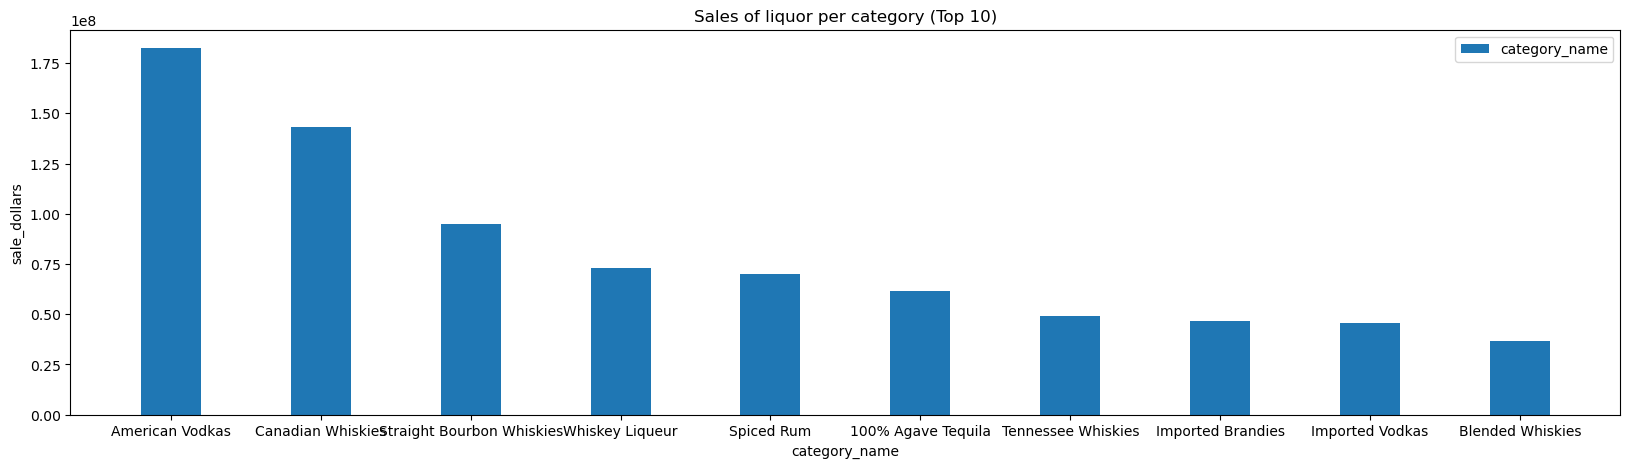

In [45]:
fig = plt.figure(figsize = (20, 5))
 
# creating the bar plot
plt.bar(df_category[:10]['category_name'], df_category[:10]['sale_dollars'],
        label ='category_name',width = 0.4)
 
plt.xlabel("category_name")
plt.ylabel("sale_dollars")
plt.title("Sales of liquor per category (Top 10)")
plt.legend(loc='best')
plt.show()

In [46]:
df_month = df[['date','sale_dollars']]

In [47]:
df_month.head()

,date,sale_dollars
1,2022-03-01,81.00
2,2021-05-26,425.16
3,2022-02-07,297.00
4,2022-01-12,62.72
5,2020-02-20,28.08


In [48]:
df_month.set_index('date',inplace=True)
df_month.index = pd.to_datetime(df_month.index)
df_month_new = df_month.resample('MS').sum()

In [49]:
df_month_new.head(10)

,sale_dollars
date,
2019-01-01,21403730.52
2019-02-01,22559476.91
2019-03-01,22762257.28
2019-04-01,25451859.28
2019-05-01,29801762.16
2019-06-01,26411373.47
2019-07-01,28232520.59
2019-08-01,26040850.84
2019-09-01,25768012.09


In [50]:
df_month_new.shape

(42, 1)

<AxesSubplot:xlabel='date'>

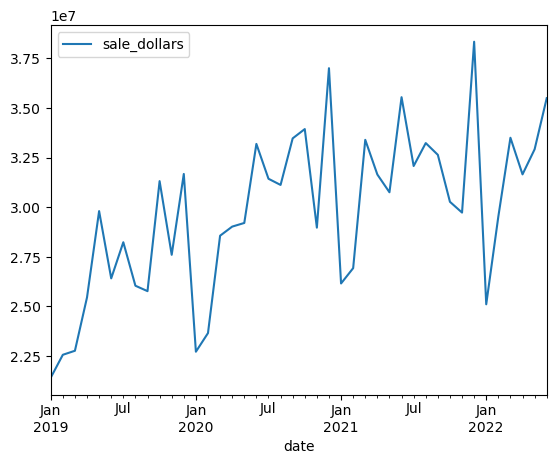

In [51]:
df_month_new.plot()

In [52]:
# we need test the stationarity
# we will use adfuller from library
from statsmodels.tsa.stattools import adfuller
result_test_data = adfuller(df_month_new['sale_dollars'])

In [53]:
# we use F-test to evaulate the result
# We assume H0: the result is not stationary ,H1:the result is stationary
def adfuller_test(sale_dollars):
    result = adfuller(sale_dollars)
    label_list = ['F-test','P-value','Lags','Number of observations']
    for value,label in zip(result,label_list):
        print(label + ':' + str(value))
    if result[1] <=0.05:
        print('we reject the H0,we accept H1')
    else:
        print('we cannot reject H0, we need accept H0')

In [54]:
# The p-value is 0.85.it is greater then 0.05, So we can't reject the H0
adfuller_test(df_month_new['sale_dollars'])

F-test:-4.539830586974208
P-value:0.00016649885302580562
Lags:0
Number of observations:41
we reject the H0,we accept H1


In [55]:
# Differecing the date
df_month_new['sale_dollars_first_differ'] = df_month_new['sale_dollars'] - df_month_new['sale_dollars'].shift(1)

In [56]:
#when we difference 1,the p-value is 0.001,it is less then 0.05, we reject the H0, the data is stationary
adfuller_test(df_month_new['sale_dollars_first_differ'].dropna())

F-test:-6.041717506859535
P-value:1.341065385325478e-07
Lags:10
Number of observations:30
we reject the H0,we accept H1


<AxesSubplot:xlabel='date'>

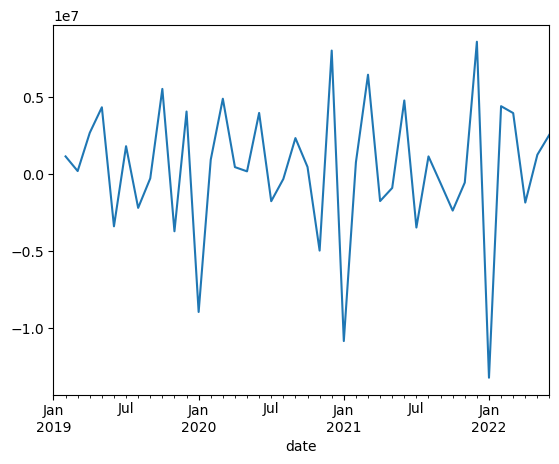

In [57]:
df_month_new['sale_dollars_first_differ'].plot()

In [58]:
# We will use ACF and PACF to find the parameter p and q
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

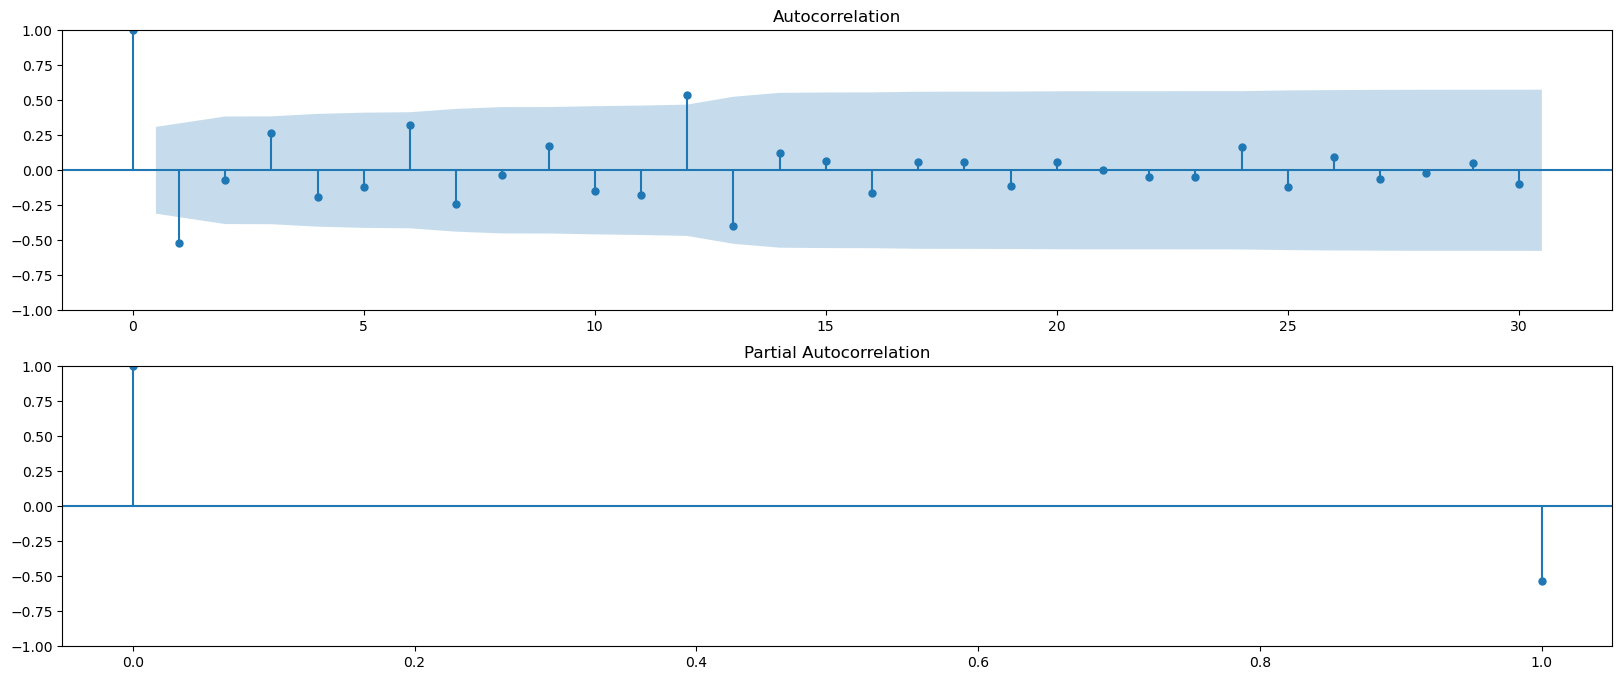

In [62]:
import statsmodels.api as sm
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_month_new['sale_dollars_first_differ'].iloc[2:],lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_month_new['sale_dollars_first_differ'].iloc[2:],lags=1,ax=ax2)


In [63]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 


In [64]:
# load dataset
# evaluate parameters
p_values = range(0, 3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_month_new['sale_dollars_first_differ'].dropna().values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=4990815.295
ARIMA(0, 0, 1) RMSE=3691541.810
ARIMA(0, 0, 2) RMSE=3757320.721
ARIMA(0, 1, 0) RMSE=8663157.171
ARIMA(0, 1, 1) RMSE=5013510.350
ARIMA(0, 1, 2) RMSE=3666144.187
ARIMA(0, 2, 0) RMSE=15891010.248
ARIMA(0, 2, 1) RMSE=8812918.056
ARIMA(0, 2, 2) RMSE=5445214.281
ARIMA(1, 0, 0) RMSE=4290552.814
ARIMA(1, 0, 1) RMSE=3785702.669
ARIMA(1, 0, 2) RMSE=3830788.299
ARIMA(1, 1, 0) RMSE=6919786.509
ARIMA(1, 1, 1) RMSE=4344312.842
ARIMA(1, 1, 2) RMSE=3744329.778
ARIMA(1, 2, 0) RMSE=11796800.288
ARIMA(1, 2, 1) RMSE=7044827.618
ARIMA(1, 2, 2) RMSE=4736929.782
ARIMA(2, 0, 0) RMSE=3547838.832
ARIMA(2, 0, 1) RMSE=3616408.504
ARIMA(2, 0, 2) RMSE=3725898.825
ARIMA(2, 1, 0) RMSE=4886015.464
ARIMA(2, 1, 1) RMSE=3593373.238
ARIMA(2, 1, 2) RMSE=3637974.527
ARIMA(2, 2, 0) RMSE=8856405.960
ARIMA(2, 2, 1) RMSE=5015520.960
ARIMA(2, 2, 2) RMSE=3897146.535
Best ARIMA(2, 0, 0) RMSE=3547838.832


In [65]:
# For non-seasonal data
#p=11, d=1, q=0
from statsmodels.tsa.arima_model import ARIMA

In [66]:
model=sm.tsa.arima.ARIMA(df_month_new['sale_dollars'],order=(2,0,0))
model_fit=model.fit()

In [67]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           sale_dollars   No. Observations:                   42
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -694.492
Date:                Tue, 27 Sep 2022   AIC                           1396.983
Time:                        08:03:19   BIC                           1403.934
Sample:                    01-01-2019   HQIC                          1399.531
                         - 06-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.977e+07    1.1e+06     27.144      0.000    2.76e+07    3.19e+07
ar.L1          0.2933      0.118      2.488      0.013       0.062       0.524
ar.L2          0.2857      0.167      1.709      0.087      -0.042       0.613
sigma2       1.21e+13      0.034   3.59e+14      0.000    1.21e+13    1.21e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.75   Jarque-Bera (JB):                 0.28
Prob(Q):                              0.39   Prob(JB):                         0.87
Heteroskedasticity (H):               1.06   Skew:                            -0.12
Prob(H) (two-sided):                  0.91   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.77e+30. Standard errors may be unstable.
"""

<AxesSubplot:xlabel='date'>

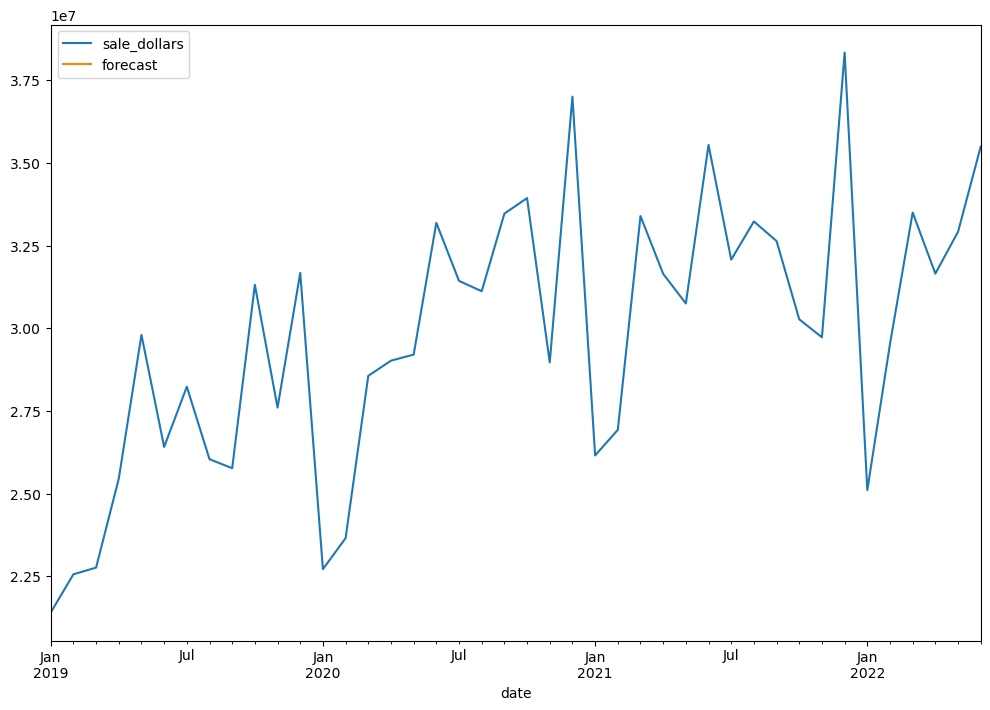

In [68]:
df_month_new['forecast']=model_fit.predict(start=50,end=70,dynamic=True)
df_month_new[['sale_dollars','forecast']].plot(figsize=(12,8))

In [72]:
# Parameter Tuning
p = d = q = range(0, 2)
pdq = list(sale_dollars.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(sale_dollars.product(p, d, q))]


for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue


NameError: name 'sale_dollars' is not defined